In [21]:
import torch.nn as nn
import wandb
import torch
import pickle
from datasets.dataset import SolarFlaresData
from torch.optim import Adam
from torch.utils.data import DataLoader
from model import CNN
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from typing import Any
from datetime import datetime
import drms
import pandas as pd
import torchvision.transforms as T

# Problem

We're exploring a challenge of predicting solar flares. This task involves telling apart active regions that are about to experience a strong solar flare (either M- or X-class) in the next 24 hours from regions that are expected to remain calm without any flares during the same period.







1- Problem formulation: what is your research problem (task)

1a- From that problem, we can formulate it as a binary hypothesis testing problem? Why that problem can be categorized as a hypothesis problem?

1b- Define your null and alternative hypotheses (in words)

1c- Mathematical describe H0 and H1? what is your statistics to be used to determine the hypothesis? what is your detection threshold?

## Mathematical Description:
$$
\begin{align*}
& H_0: P(\text{flare} \geq \text{M1} | X) > \theta_0 \\
& \text{There will  be a solar flare with intensity greater than or equal to M1 in the next 24 hours based on the magnetogram image \(X\).} \\
\\
& H_1: P(\text{flare} \geq \text{M1} | X) \leq \theta_0 \\
& \text{There will be a solar flare with intensity less than  M1 in the next 24 hours based on the magnetogram image \(X\).}
\end{align*}
$$

$$
\begin{align*}
& X: \text{Feature space representing magnetogram images.} \\
& Y: \text{Set of class labels, where } Y = \{0, 1\} \text{ for a binary classification problem.} \\
& H_0: \text{Null hypothesis.} \\
& H_1: \text{Alternative hypothesis.} \\
& \theta_0: \text{Critical probability threshold under the null hypothesis.} \\
& P: \text{Predicted probability of a solar flare based on the CNN model.} \\
\end{align*}
$$


In [ ]:
# null hypothesis H0 and alternative hypothesis H1
# H0 : there will be a flare of intensity greater than or equal to  M1
# H1 : there will not be a flare of intensity greater than or equal to  M1

# the max flare in the prediction period to the flare intensity of M1

2-  After you get the problem, now, how to solve it?

2a- in the past, how was the problem can be addressed (without using ML)?

2b- what research gaps, drawbacks of those conventional problems

2c- Why we need ML for that problem

3- Now, using ML-driven solution

3a- what possible ML solutions (regression, classification, reinforcement, etc.)

3b- why you choose CNN-based classification

# Dataset

Our dataset can be mathematically described as follows
$$ \ \text{Dataset:} \quad \{(X_i, Y_i) \mid X_i \in \mathbb{R}^{128 \times 128}, Y_i \in \{0, 1\}\} \$$

Our dataset consists of pairs $(X_i, Y_i)$ where $X_i$ represents a 128×128 magnetogram image and $Y_i$ is either 0 or 1, indicating the absence or presence of a solar flare with intensity greater than or equal to M1 in the next 24 hours time period.

#### Magnetograms Preprocesssing

To preprocess the magnetograms we use the following approach : 

1. Check for NaN Values:

    - Examine each magnetogram for the presence of NaN (Not a Number) values.

2. Handle NaN Values:

    - If NaN values are found, decide on a strategy:
        - Exclude the magnetogram from further processing.
        
3. Apply Z-score Standardization:

    - Standardize each magnetogram using Z-score normalization.
    - Compute the mean ($\mu$) and standard deviation ($\sigma$) of the pixel values across all magnetograms.
    - For each pixel value $x$ in a magnetogram, calculate the Z-score using the formula: $$\Z = \frac{{X - \mu}}{{\sigma}}$$
    - This ensures that pixel values are centered around zero and scaled by the standard deviation.
4. Reshape the magnetogram: 
- active regions magnetograms have different sizes; that is why we need to reshape them to have similar dimensions. 
In this work,we reshape the magnetograms to 128 x 128. 
5. Output Preprocessed Magnetograms:

    The result of these preprocessing steps is a set of magnetograms ready for use in our CNN model.

The diagram below illustrates the magnetogram preprocessing steps

![alternative text](magnetogram.drawio.png)

#### Labelling Process

1. Initialize Parameters:
- Set the observation period duration to 24 hours.
- Set the prediction period duration to the 24 hours following the observation period.
- Define the step size for sliding the time window as 96 minutes.

2. Extract Samples:
- Start with the initial 24-hour time window.
- Slide the time window through the active region sequence with a step size of 96 minutes.
- Extract samples from each 24-hour subsequence.

3. Label Samples:

- For each extracted sample:

    - If the sample exhibits an M- or X-class flare in the prediction period, assign it to the positive class.
    
    - If the sample has no flare of any class in both the observation and prediction periods, assign it to the negative class.
4. Repeat:
- Continue sliding the time window with the defined step size until the entire active region sequence is covered.

To get the labels given the SHARP/SMARP dataset magnetograms and the NOAA GOES flare intensity dataset, we use the following approach:

4- Elaborate on you dataset

4a- mathematical describe the statistics in point 1c using the features in your data

4b- mathematically describe the target/output (H0 or H1) using the labels in your data

4c- how to determine that labels

4c-i present the flowchart of all steps of pre-processing data

4c-ii present the threshold in point 1c

4c-iii explain what is the contribution and novelty of such pre-processing step

In [12]:
def read_df_from_pickle(path):
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df


class SolarFlaresData(Dataset):
    def __init__(self, df, random_undersample=True):
        self.resize_transform = T.Resize((128, 128))
        self.df = self.random_undersample(df) if random_undersample else df

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.df.loc[idx, "params"]).to(torch.float32),
            self.resize_transform(
                torch.from_numpy(self.df.loc[idx, "magnetogram"])
                .unsqueeze(0)
                .to(torch.float32)
            ),
            torch.tensor(self.df.loc[idx, "label"]),
        )

    def random_undersample(self, df):
        positive_samples_count = len(df[df.label == 1])
        negative_samples_count = len(df[df.label == 0])
        samples_dropped_count = negative_samples_count - positive_samples_count
        indices_to_drop = np.random.choice(
            df[df.label == 0].index, samples_dropped_count, replace=False
        )
        df_dropped = df.drop(indices_to_drop)
        return df_dropped.reset_index()

    def __len__(self):
        return self.df.shape[0]

# Model

Convolutional Neural Networks (CNNs) are powerful tools in image analysis. When applied to predicting solar flares from magnetogram images, they shine because they're adept at automatically learning and recognizing complex patterns in the images. The spatial structures and hierarchies in magnetogram images align well with CNNs, making them an excellent choice for detecting subtle features that may indicate impending solar flare activity

![alternative text](cnn_arch.png)

![alternative text](cnn_archdrawio.png)

5- elaborate on your CNN

(nothing new here, just present its architecture, layers, etc.)

A Convolutional Neural Network (CNN) model is employed on the line-of-sight magnetogram. The optimization process is facilitated by the Adam optimizer, which seeks to minimize a binary cross-entropy loss function.

In [15]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.ModuleList(
            [cnn_block(11, 1), cnn_block(11, 64)]
            + [cnn_block(3, 64), cnn_block(3, 64), cnn_block(3, 64)]
        )
        self.linear = nn.Linear(64, 128)
        self.bn = nn.BatchNorm1d(128)
        self.drop_out = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop_out2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 2)

    def forward(self, x):
        for idx, l in enumerate(self.cnn):
            x = l(x)
        # print(x.shape)
        x = x.squeeze(2).squeeze(2).reshape(-1, 64)
        x = self.linear(x)
        # print(x.shape)
        x = self.bn(x)
        # print(x.shape)
        x = self.drop_out(x)
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.bn2(x)
        # print(x.shape)
        x = self.drop_out2(x)
        # print(x.shape)
        x = self.linear3(x)
        return x


class cnn_block(nn.Module):
    def __init__(self, filter_size, in_channels):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=filter_size
        )
        self.bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        return x


class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=4, hidden_size=64, num_layers=2, batch_first=True
        )

    def forward(self, x):
        return self.lstm(x)

# Training

6- training

6a- explain the difficulty of training, imbalanced data problem? link it to point 1b to explain why it happens

6b- you solution to address this imbalanced data problem? you proposed loss function 

6c- evaluation of the training? the convergence of the loss function

6d- comparison between different training settings (the table that you already made)

6e- comparison between different CNN architecture (CNN vs residual-CNN, etc.)

6f- comparison between different loss function (your proposed loss function, BCE, MSE, FL, etc.)

Two loss functions are tried: Focal Loss and Binary Cross Entropy Loss. Focal Loss is used  because it's adept at handling the challenge of imbalanced data, especially evident in the solar flares dataset where strong flares are rare. This choice allows  to pay special attention to and accurately address these infrequent but significant events.

Focal Loss :                                                     
               $$\text{FL}(p_t) = -(1 - p_t)^\gamma \log(p_t)$$


$$\text{Binary Cross-EntropyLoss:   BCE}(y_i, p_i) = y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i)$$


In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        focal_loss = (1 - torch.exp(-ce_loss)) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return torch.mean(focal_loss)
        elif self.reduction == "sum":
            return torch.sum(focal_loss)
        else:
            return focal_loss

regions in train set [6206 1]
regions in validation set[6327 2]


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.17batch/s, valid_loss=0.00478]


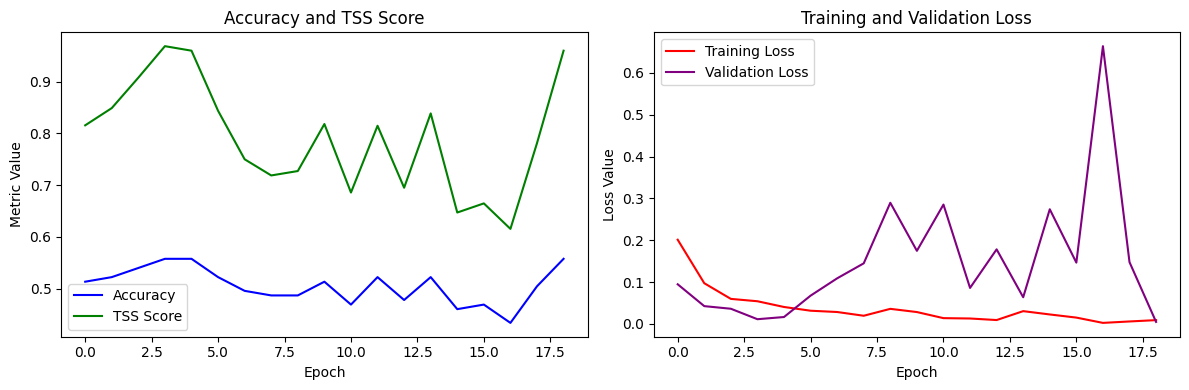

Experiment summary
Number of epochs 20
batch size 64
train set length 170 with 39 positive examples and 131 negative examples
test set length 113 with 55 positive examples and 58 negative examples
max accuracy 0.5575221238938053
max tss score 0.96875


In [22]:
def read_df_from_pickle(path):
    with open(path, "rb") as f:
        df = pickle.load(f)
    return df


def compute_accuracy(predictions, correct):
    return (predictions == correct).sum().item() / predictions.shape[0]


def confusion(prediction, target):
    confusion_vector = prediction / target
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float("inf")).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives


def compute_tss(prediction, target):
    TP, FP, TN, FN = confusion(prediction, target)
    # print(TP, FP, TN, FN)
    N = TN + FP
    P = TP + FN
    return TP / P - FP / N


def region_based_split(dataset_df, train_regions, test_regions):
    train_df = dataset_df[dataset_df.region_no.isin(set(train_regions))]
    test_df = dataset_df[dataset_df.region_no.isin(set(test_regions))]
    return train_df, test_df


lr = 0.001
batch_size = 64
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
df = read_df_from_pickle("data/SHARP/SHARP.pkl")
train_df, test_df = region_based_split(
    df, train_regions=[1, 6206], test_regions=[2, 6327]
)
print(f"regions in train set {train_df.region_no.unique()}")
print(f"regions in validation set{test_df.region_no.unique()}")

train_dataset = SolarFlaresData(train_df.reset_index(), random_undersample=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SolarFlaresData(test_df.reset_index(), random_undersample=False)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

model = CNN()
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
optimizer = Adam(model.parameters(), lr=0.001)
model.train()


def train(epochs, model, optimizer):
    train_losses = []
    val_losses = []
    accuracies = []
    tss_scores = []
    for epoch in range(1, num_epochs):
        epoch_train_losses = []
        model.train()
        with tqdm(train_loader, unit="batch") as tepoch:
            for _, data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                data, target = data.to(device), target.to(device)
                logits = model(data)
                predictions = logits.argmax(dim=1, keepdim=True).squeeze()
                loss = criterion(logits, target)
                loss.backward()
                optimizer.step()
                epoch_train_losses.append(loss.item())
                # acc = compute_accuracy(predictions, target)
                # tss = compute_tss(acc)
                tepoch.set_postfix(loss=loss.item())

        model.eval()
        with torch.no_grad():
            with tqdm(test_loader, unit="batch") as tepoch:
                batch_correct = []
                batch_tss = []
                batch_valid_losses = []
                all_predictions = []
                all_targets = []
                for _, data, target in tepoch:
                    tepoch.set_description(f"Epoch {epoch}")
                    data, target = data.to(device), target.to(device)
                    logits = model(data)
                    predictions = logits.argmax(dim=1, keepdim=True).squeeze()
                    all_predictions.append(predictions)
                    all_targets.append(target)
                    loss = criterion(logits, target)
                    batch_valid_losses.append(loss.item())
                    correct = (predictions == target).sum().item()
                    batch_acc = compute_accuracy(predictions, target)
                    batch_correct.append(correct)

                    tepoch.set_postfix(
                        valid_loss=loss.item(),
                    )
        train_losses.append(np.mean(epoch_train_losses))
        val_losses.append(np.mean(batch_valid_losses))
        accuracies.append(np.sum(batch_correct) / len(test_dataset))
        all_predictions = torch.cat(all_predictions, axis=0)
        all_targets = torch.cat(all_targets, axis=0)
        # print(all_targets.shape, all_predictions.shape)
        tss_scores.append(compute_tss(all_predictions, all_targets))
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(len(accuracies)), accuracies, label="Accuracy", color="blue")
    plt.plot(range(len(tss_scores)), tss_scores, label="TSS Score", color="green")
    plt.title("Accuracy and TSS Score")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_losses)), train_losses, label="Training Loss", color="red")
    plt.plot(
        range(len(val_losses)), val_losses, label="Validation Loss", color="purple"
    )
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Experiment summary")
    print(f"Number of epochs {num_epochs}")
    print(f"batch size {batch_size}")
    print(
        f"train set length {len(train_df)} with {len(train_df[train_df.label == 1])} positive examples and {len(train_df[train_df.label == 0])} negative examples"
    )

    print(
        f"test set length {len(test_df)} with {len(test_df[test_df.label == 1])} positive examples and {len(test_df[test_df.label == 0])} negative examples"
    )
    print(f"max accuracy {max(accuracies)}")
    print(f"max tss score {max(tss_scores)}")

In [4]:
df = read_df_from_pickle("data/SHARP/SHARP.pkl")

In [11]:
df

,T_REC,region_type,region_no,NOAA_ARS,params,magnetogram,label
0,2015-12-23 01:12:00,harp,6206,12473,"[-0.0100475028260637, 1.2602700352173024, 0.99...","[[-0.06619508896585617, -0.05401688210435899, ...",1
1,2015-12-23 02:48:00,harp,6206,12473,"[0.066513399626304, 1.2994691822566444, 1.0664...","[[-0.22045237587815394, -0.204214766729491, -0...",1
2,2015-12-23 04:24:00,harp,6206,12473,"[0.1669003090659236, 1.328868542536151, 1.1183...","[[-0.032705020096738896, -0.041838675242861785...",1
3,2015-12-23 06:00:00,harp,6206,12473,"[0.2331366084904823, 1.2643052415301756, 1.161...","[[-0.08040299697093622, -0.043868376386444655,...",1
4,2015-12-23 07:36:00,harp,6206,12473,"[0.2683990988316146, 1.29255168572029, 1.14740...","[[-0.10881881298109633, -0.13013067498871642, ...",1
...,...,...,...,...,...,...,...
459,2010-05-04 21:12:00,harp,2,11064,"[-0.0008347801243265, -1.420259872620072, -0.7...","[[-0.031690169524947465, 0.020067209636415593,...",0
460,2010-05-04 22:48:00,harp,2,11064,"[0.1030466103400896, -1.420259872620072, -0.73...","[[-0.07532874411197907, -0.08040299697093622, ...",0
461,2010-05-05 00:36:00,harp,2,11064,"[0.0387163914745106, -1.420259872620072, -0.73...","[[0.0028147499159612405, -0.021541663807033137...",0
462,2010-05-05 02:12:00,harp,2,11064,"[0.11257701313499, -1.420259872620072, -0.7403...","[[0.2139036688485792, 0.3113293237405567, 0.32...",0


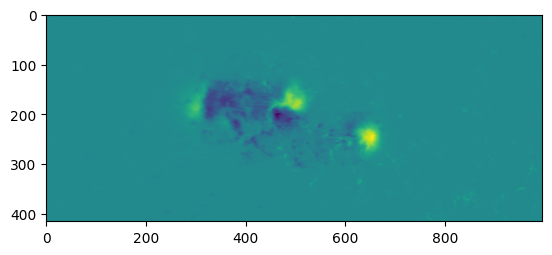

In [6]:
plt.imshow(df.magnetogram[0])

In [10]:
plt.imshow(
    T.Resize((128, 128))(torch.from_numpy(df.magnetogram[0])).reshape(128, 128, 1)
)

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [996] and output size of [128, 128]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

7- testing/inference

7a- confusion matrix
